Node2Vec representation for measuring the similarity of research projects in funding landscape
===

This is a notebook for our research project named "the effect of research grant novelty and its future impact"



In [7]:
# load packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import pairwise_distances_argmin,cosine_similarity
import networkx as nx
import seaborn as sns
%matplotlib inline

## Construct Subject co-ocurence network

In [8]:
# load node2vec packages
import node2vec
from gensim.models import Word2Vec

In [2]:
# rewrite the network by edgelist
for y in range(2006,2019):
    input = './graph/year'+str(y)+'.csv' #edgelist
    edge = pd.read_csv(input,header=None,names =["S","D","Weight"])
    edge_trip = []
    for i in edge.index:
        if edge.loc[i,'S']!= edge.loc[i,'D']:
            edge_trip.append((edge.loc[i,'S'],edge.loc[i,'D'],edge.loc[i,'Weight']))
    G = nx.Graph()
    G.add_weighted_edges_from(edge_trip)
    output = './graph/year'+str(y)+'_NoSelfloop.edgelist'
    nx.write_weighted_edgelist(G, output)

## Node2Vec of subject coocurence networks

[Node2Vec](https://snap.stanford.edu/node2vec/) is used to embedding the subject cooccurence network extracted from UK research grants subject classification.

In [12]:
# node2vec embedding
input = './graph/year2016.edgelist' #edgelist
output = './graph/jcr2016.emd' # embedding file

dimensions = 32
walk_length = 100
num_walks = 500
window_size = 5
iter = 1     #'Number of epochs in SGD
workers = 8  #'Number of parallel workers. Default is 8.'
p = 1       #'Return hyperparameter. Default is 1.'
q = .5       #'Inout hyperparameter. Default is 1.'
weighted = True #'Boolean specifying (un)weighted. Default is unweighted.')
directed = False #'Graph is (un)directed. Default is undirected.')

def read_graph():
    '''
    Reads the input network in networkx.
    '''
    if weighted:
        G = nx.read_edgelist(input, nodetype=int, data=(('weight',int),), create_using=nx.DiGraph())
    else:
        G = nx.read_edgelist(input, nodetype=int, create_using=nx.DiGraph())
        for edge in G.edges():
            G[edge[0]][edge[1]]['weight'] = 1

    if not directed:
        G = G.to_undirected()
    print(len(G))
    return G

def learn_embeddings(walks):
    '''
    Learn embeddings by optimizing the Skipgram objective using SGD.
    '''
    walks = [[str(i) for i in walk] for walk in walks]
    model = Word2Vec(walks, size=dimensions, window=window_size, min_count=0, sg=1, workers=workers, iter=iter)
    model.wv.save_word2vec_format(output)
    return

'''
Pipeline for representational learning for all nodes in a graph.
'''
print('reading...')
nx_G = read_graph()
G = node2vec.Graph(nx_G, directed, p, q)
print('preprocess...')
G.preprocess_transition_probs()
print('simulate...')
walks = G.simulate_walks(num_walks, walk_length)
print('embedding...')
learn_embeddings(walks)
print('Finished')

reading...
101
preprocess...
simulate...
Walk iteration:
embedding...00 48 / 500500 101 / 500500/ 500 500 167 / 500 181 / 500 241 / 500 246 / 500 250 / 500 / 500 263 / 500 500 / 500 500 / 500 / 500 408 / 500 412 / 500 431 / 500500 497 / 500
Finished


## Mesure the similarity of pairwise subjects in the network

In [15]:
#load the results of node2vec
emd = pd.read_csv('./graph/jcr2016.emd',sep=' ',skiprows=[0],header=None,index_col=0)
idx = emd.index
emd = normalize(emd)

# read the one-to-one correspondence between subjects' codes and names
df_subject_code = pd.read_pickle('subject_code.pkl') # read the corresponding research subjects
df_code_subject = df_subject_code.reset_index()
df_code_subject = df_code_subject.rename(columns={'index':'Subject_name'})
df_code_subject = df_code_subject.set_index('Number')

# calculate the simialrity between subjects
cos_sim = cosine_similarity(emd)
s_name = []
for i in idx:
    s_name.append(df_code_subject.loc[i,'Subject_name'])
df_cos_sim = pd.DataFrame(cos_sim,columns=s_name,index=s_name)
df_cos_sim.head()

,Agri-environmental science,Climate & Climate Change,Infection,"Tools, technologies & methods",Sociology,Geosciences,Development studies,Animal Science,Microbial sciences,Human Geography,...,Chem. React. Dyn. & mechanisms,Solar & terrestrial physics,Particle Astrophysics,Social Work,Dance,Classics,Library & information studies,Blood,Facility Development,Nuclear Physics
Agri-environmental science,1.000000,0.734283,0.249300,0.832085,0.527059,0.713756,0.650639,0.853508,0.832943,0.608423,...,0.333893,0.317959,0.263911,0.413369,0.405950,0.367869,0.382900,0.057331,0.325026,0.368196
Climate & Climate Change,0.734283,1.000000,0.168220,0.687910,0.583372,0.891943,0.745976,0.547778,0.678170,0.645687,...,0.422934,0.508962,0.321318,0.380420,0.401373,0.377261,0.474247,0.158070,0.365440,0.318903
Infection,0.249300,0.168220,1.000000,0.210787,0.237543,0.177875,0.184373,0.187586,0.201566,0.181112,...,0.040883,0.130558,0.252766,0.169527,0.187686,0.138820,0.133662,0.712299,0.104679,0.171366
"Tools, technologies & methods",0.832085,0.687910,0.210787,1.000000,0.579778,0.693433,0.620718,0.861469,0.868293,0.593593,...,0.526441,0.444938,0.496462,0.449160,0.358174,0.390779,0.374083,0.119244,0.417360,0.569438
Sociology,0.527059,0.583372,0.237543,0.579778,1.000000,0.575815,0.879217,0.484827,0.478227,0.886307,...,0.262441,0.303710,0.177624,0.793566,0.636771,0.558178,0.669323,0.256382,0.219849,0.194249


Text(0.5, 0, 'pairwise cosine similarity')

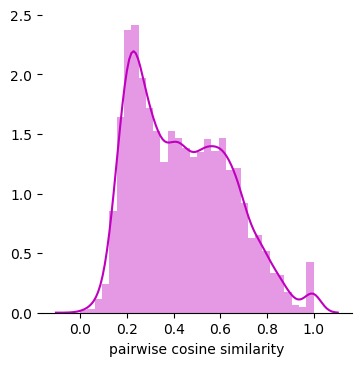

In [22]:
# plot the distribution of cosine similarity
f, axes = plt.subplots(1, 1, figsize=(4, 4), dpi=100)
sns.despine(left=True)
sns.distplot(cos_sim_list, color="m")
plt.xlabel('pairwise cosine similarity',fontsize=10)